# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
%load_ext autoreload
%autoreload 2

In [8]:

from maddpg_agent import MADDPGAgent
import time
agent = MADDPGAgent(num_agents, state_size, action_size, random_seed=47, batch_size=256, buffer_size=int(1e6), use_batch_norm=True)
episode_scores = []
best_score=0.
start_time = time.time()
for i in range(5000):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset_noise()
    game_time = 0
    while True:
        # states[0] is the observation of agent 0 and states[1] is the observation of agent 1
        # actions[0] is the action chosen by agent 0 and actions[1] is the action chosen by agent 1
        # selection of action is always based only on the observation
        actions = agent.act(states)

        # Apply these actions to the environment and receive the next state, rewards, and doneness
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        
        #print("actions: {} rewards: {}".format(actions, rewards))
        
        dones = env_info.local_done
        
        # Send in these two states, actions, next_states, and dones into the agent
        agent.step(states,actions,rewards,next_states, dones)
        scores += np.array(env_info.rewards)
        states = next_states
        if np.any(dones):
            break
        game_time += 1
    
    mean_last_10 = 0.
    mean_last_100 = 0.
    episode_scores.append(np.max(scores))

    if i >= 10:
        mean_last_10 = np.mean(episode_scores[i-10:i])
        if i>= 100:
            mean_last_100 = np.mean(episode_scores[i-100:i])
            if mean_last_100 >= 0.5:
                print("Solved in {} episodes with mean score: {:.4f}".format(i, mean_last_100))
                break
    elapsed_time = int(time.time() - start_time)
    sfmt = "\rEpisode {:4d} Score {:.2f} Mean Last 10 {:.4f} Mean Last 100 {:.4f} Elapsed {:6d}".format(i,
                                                                                  np.max(scores),
                                                                                  mean_last_10,
                                                                                  mean_last_100,
                                                                                  elapsed_time)
    print(sfmt, end="")
    if i%100 == 0 and i>0:
        print(sfmt)


Episode  100 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0030 Elapsed    121
Episode  200 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0000 Elapsed    257
Episode  300 Score 0.00 Mean Last 10 0.0290 Mean Last 100 0.0029 Elapsed    410
Episode  400 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0068 Elapsed    571
Episode  500 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0039 Elapsed    730
Episode  600 Score 0.00 Mean Last 10 0.0100 Mean Last 100 0.0030 Elapsed    876
Episode  700 Score 0.10 Mean Last 10 0.0100 Mean Last 100 0.0059 Elapsed   1050
Episode  800 Score 0.10 Mean Last 10 0.0100 Mean Last 100 0.0206 Elapsed   1246
Episode  900 Score 0.09 Mean Last 10 0.0500 Mean Last 100 0.0298 Elapsed   1484
Episode 1000 Score 0.00 Mean Last 10 0.0600 Mean Last 100 0.0391 Elapsed   1738
Episode 1100 Score 0.10 Mean Last 10 0.0670 Mean Last 100 0.0416 Elapsed   1993
Episode 1200 Score 0.10 Mean Last 10 0.1060 Mean Last 100 0.0591 Elapsed   2267
Episode 1300 Score 0.09 Mean Last 10 0.0

Episode 2431 Score 2.60 Mean Last 10 0.7190 Mean Last 100 0.6517 Elapsed  13579Solved in 2432 episodes with mean score: 0.6737
Episode 2432 Score 0.40 Mean Last 10 0.9090 Mean Last 100 0.6737 Elapsed  13594Solved in 2433 episodes with mean score: 0.6727
Episode 2433 Score 0.70 Mean Last 10 0.8090 Mean Last 100 0.6727 Elapsed  13619Solved in 2434 episodes with mean score: 0.6687
Episode 2434 Score 0.70 Mean Last 10 0.8490 Mean Last 100 0.6687 Elapsed  13644Solved in 2435 episodes with mean score: 0.6757
Episode 2435 Score 0.40 Mean Last 10 0.7700 Mean Last 100 0.6757 Elapsed  13659Solved in 2436 episodes with mean score: 0.6757
Episode 2436 Score 0.10 Mean Last 10 0.8000 Mean Last 100 0.6757 Elapsed  13665Solved in 2437 episodes with mean score: 0.6757
Episode 2437 Score 0.70 Mean Last 10 0.8000 Mean Last 100 0.6757 Elapsed  13695Solved in 2438 episodes with mean score: 0.6807
Episode 2438 Score 0.30 Mean Last 10 0.8200 Mean Last 100 0.6807 Elapsed  13708Solved in 2439 episodes with mea

KeyboardInterrupt: 

In [10]:
import pickle as pkl

In [29]:
pkl.dump(episode_scores, open("data/episode_scores.pkl", "wb"))

In [30]:
import torch
torch.save(agent.agents[0].actor_local.state_dict(),open("data/actor_local0.pt","wb"))
torch.save(agent.agents[1].actor_local.state_dict(), open("data/actor_local1.pt","wb"))
torch.save(agent.agents[0].critic_local.state_dict(),open("data/critic_local0.pt","wb"))
torch.save(agent.agents[1].critic_local.state_dict(), open("data/critic_local1.pt","wb"))

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

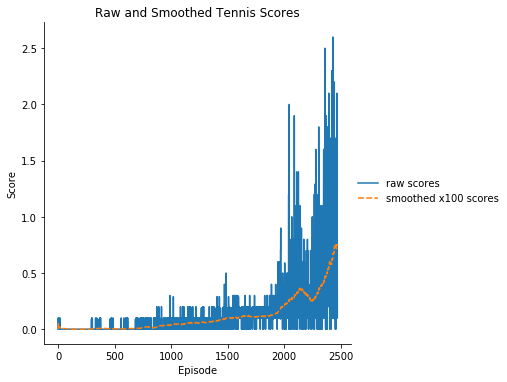

In [32]:
d = {'raw scores':episode_scores, 'smoothed x100 scores':[]}
d['smoothed x100 scores'] = [np.mean(episode_scores[max(i-100,0):i+1]) for i in range(len(episode_scores))]
pdf = pd.DataFrame(d)
ax=sns.relplot(data=pdf,kind='line')
ax.set(xlabel="Episode",ylabel="Score", title="Raw and Smoothed Tennis Scores")
ax.savefig("output/scores.png")

In [ ]:
try: env
except: env = None
from maddpg_agent import MADDPGAgent
from unityagents import UnityEnvironment
import numpy as np
import torch
if env:
    env.close()
env = UnityEnvironment(file_name='./Tennis_Linux/Tennis.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
agent = MADDPGAgent(num_agents, state_size, action_size, random_seed=47, batch_size=256, buffer_size=int(1e6), use_batch_norm=True)
agent.agents[0].actor_local.load_state_dict(torch.load("./data/actor_local0.pt"))
agent.agents[1].actor_local.load_state_dict(torch.load("./data/actor_local1.pt"))


for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset_noise()
    game_time = 0
    while True:
        # states[0] is the observation of agent 0 and states[1] is the observation of agent 1
        # actions[0] is the action chosen by agent 0 and actions[1] is the action chosen by agent 1
        # selection of action is always based only on the observation
        actions = agent.act(states)

        # Apply these actions to the environment and receive the next state, rewards, and doneness
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards        
        dones = env_info.local_done
        
        # Send in these two states, actions, next_states, and dones into the agent
        scores += np.array(env_info.rewards)
        states = next_states
        if np.any(dones):
            break
    print("Game {} Score {}".format(i+1, np.max(scores)))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Game 1 Score 0.0
Game 2 Score 0.0
